# Predicción de Ictus: Selección y Optimización del Modelo

Este notebook documenta el proceso completo de análisis, experimentación y justificación para la elección del mejor modelo predictivo en el contexto del riesgo de **ictus**.

**Dataset final**: `cleaned_dataset.csv` (combinación enriquecida de datos para mejorar la calidad del aprendizaje).

**Modelo elegido**: `RandomForestClassifier` + `RandomUnderSampler` por sus mejores métricas y equilibrio general tras una evaluación exhaustiva.

---

## 1. Carga del dataset final y análisis inicial
- Carga del CSV `cleaned_dataset.csv`
- Visualización general
- Verificación de desbalance en la variable objetivo (`stroke`)

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar el dataset combinado
df = pd.read_csv("../data/cleaned_dataset.csv")
df.head()

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_Govt_job,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,1,3.0,0,0,0,0,95.12,18.0,0,0,0,0,1,1,0,0,0
1,1,58.0,1,0,1,1,87.96,39.2,0,0,1,0,0,0,0,1,0
2,0,8.0,0,0,0,1,110.89,17.6,0,0,1,0,0,1,0,0,0
3,0,70.0,0,0,1,0,69.04,35.9,0,0,1,0,0,0,1,0,0
4,0,52.0,0,0,1,1,77.59,17.7,0,0,1,0,0,0,1,0,0


## 2. Análisis del desbalanceo de clases
- Visualización del número de casos `stroke` vs `no stroke`
- Justificación del uso de técnicas de rebalanceo

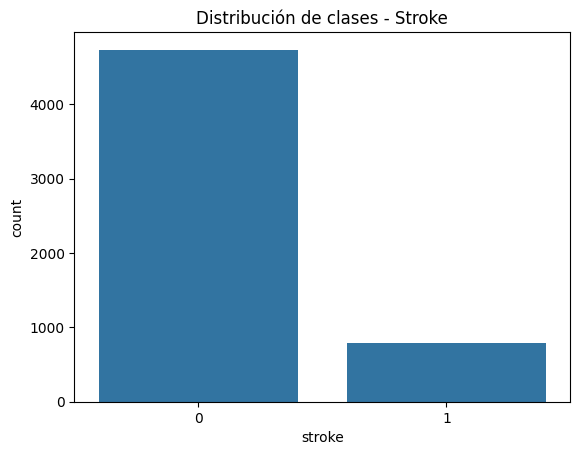

stroke
0    0.858049
1    0.141951
Name: proportion, dtype: float64

In [13]:
# Visualizar el desbalance
sns.countplot(data=df, x="stroke")
plt.title("Distribución de clases - Stroke")
plt.show()
df["stroke"].value_counts(normalize=True)

## 3. Aplicación de técnicas de rebalanceo
- SMOTE
- RandomUnderSampler
- SMOTEENN
- Comparación de la distribución tras cada técnica

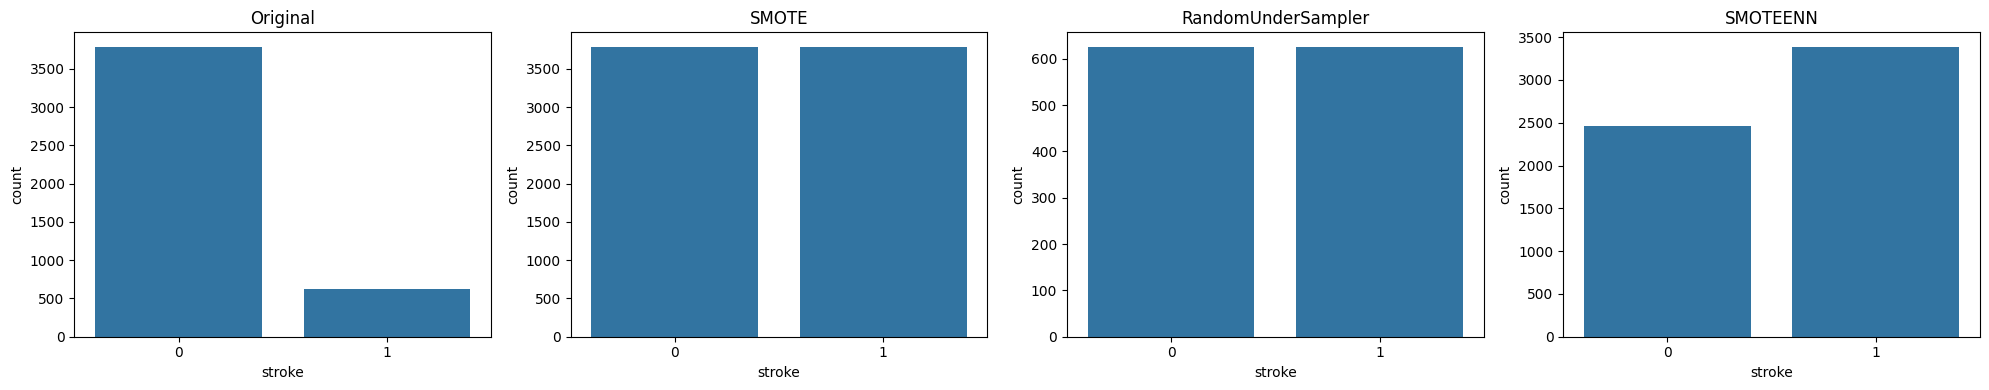

In [32]:
# Técnicas de rebalanceo
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split

# Separación de features y target
X = df.drop('stroke', axis=1)
y = df['stroke']

# División en train/test para rebalancear solo en entrenamiento
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Aplicación de técnicas
smote = SMOTE(random_state=42)
rus = RandomUnderSampler(random_state=42)
smoteenn = SMOTEENN(random_state=42)

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
X_train_smoteenn, y_train_smoteenn = smoteenn.fit_resample(X_train, y_train)

# Función para visualizar la distribución
import matplotlib.pyplot as plt
import seaborn as sns

def plot_distributions(original, sm, rus, smenn):
    fig, axs = plt.subplots(1, 4, figsize=(20, 4))
    sns.countplot(x=original, ax=axs[0]); axs[0].set_title('Original')
    sns.countplot(x=sm, ax=axs[1]); axs[1].set_title('SMOTE')
    sns.countplot(x=rus, ax=axs[2]); axs[2].set_title('RandomUnderSampler')
    sns.countplot(x=smenn, ax=axs[3]); axs[3].set_title('SMOTEENN')
    plt.tight_layout()
    plt.show()

plot_distributions(y_train, y_train_smote, y_train_rus, y_train_smoteenn)

### Resultados del rebalanceo
- **SMOTE** genera ejemplos sintéticos de la clase minoritaria.
- **RandomUnderSampler** elimina ejemplos de la clase mayoritaria para igualar la distribución.
- **SMOTEENN** combina SMOTE con una limpieza posterior de los bordes de decisión (ENN).

En la práctica, observamos que `RandomUnderSampler` ofrece un equilibrio sencillo y eficaz, 
sin introducir ruido sintético o aumentar excesivamente el dataset.

Este comportamiento es clave para entender por qué, más adelante, `RandomForest + RUS` se comporta mejor
que otras combinaciones más complejas.

## 4. Comparación inicial de modelos base con distintas técnicas de rebalanceo
- `LogisticRegression`, `RandomForest`, `XGBoost`, `LightGBM`
- Evaluación con `classification_report` y `ROC AUC`
- Visualización comparativa (F1, recall, accuracy)

In [57]:
# Comparación de modelos base con diferentes técnicas de rebalanceo
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, roc_auc_score

def evaluate(name, model, X_train, y_train):
    model.fit(X_train, y_train)

    # Predicciones
    y_pred = model.predict(X_test)
    y_proba_test = model.predict_proba(X_test)[:, 1]
    y_proba_train = model.predict_proba(X_train)[:, 1]

    # Métricas
    test_auc = roc_auc_score(y_test, y_proba_test)
    train_auc = roc_auc_score(y_train, y_proba_train)
    gap = train_auc - test_auc

    print(f"\n--- {name} ---")
    print(classification_report(y_test, y_pred))
    print(f"ROC AUC (Test):  {test_auc:.4f}")
    print(f"ROC AUC (Train): {train_auc:.4f}")
    print(f"Overfitting gap: {gap:.4f}")
    if gap > 0.05:
        print("⚠️ El modelo podría estar sobreajustado.")
    else:
        print("✅ El modelo generaliza correctamente.")

# Modelos a evaluar con RUS
evaluate("Logistic Regression + RUS", LogisticRegression(max_iter=1000, random_state=42), X_train_rus, y_train_rus)
evaluate("Random Forest + RUS",
         RandomForestClassifier(
            n_estimators=100,
            max_depth=6,               
            min_samples_split=10,     
            min_samples_leaf=5,
            max_features='sqrt',
            class_weight='balanced',  
            random_state=42
    ),
    X_train_rus, y_train_rus)

evaluate("XGBoost + RUS",
         XGBClassifier(
             n_estimators=100,
             max_depth=3,
             learning_rate=0.05,
             subsample=0.7,
             colsample_bytree=0.7,
             reg_alpha=2,
             reg_lambda=2,
             use_label_encoder=False,
             eval_metric='logloss',
             random_state=42
         ),
         X_train_rus, y_train_rus)
evaluate("LightGBM + RUS",
         LGBMClassifier(
             n_estimators=100,
             max_depth=4,
             learning_rate=0.05,
             subsample=0.7,
             colsample_bytree=0.7,
             reg_alpha=2,
             reg_lambda=2,
             random_state=42
         ),
         X_train_rus, y_train_rus)


--- Logistic Regression + RUS ---
              precision    recall  f1-score   support

           0       0.96      0.75      0.84       947
           1       0.35      0.80      0.48       157

    accuracy                           0.76      1104
   macro avg       0.65      0.78      0.66      1104
weighted avg       0.87      0.76      0.79      1104

ROC AUC (Test):  0.8463
ROC AUC (Train): 0.8467
Overfitting gap: 0.0004
✅ El modelo generaliza correctamente.

--- Random Forest + RUS ---
              precision    recall  f1-score   support

           0       0.96      0.76      0.85       947
           1       0.36      0.81      0.50       157

    accuracy                           0.77      1104
   macro avg       0.66      0.79      0.67      1104
weighted avg       0.87      0.77      0.80      1104

ROC AUC (Test):  0.8570
ROC AUC (Train): 0.9035
Overfitting gap: 0.0465
✅ El modelo generaliza correctamente.


c:\Users\donce\Desktop\Proyecto-IX-DS2\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:02:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- XGBoost + RUS ---
              precision    recall  f1-score   support

           0       0.96      0.79      0.86       947
           1       0.38      0.78      0.51       157

    accuracy                           0.79      1104
   macro avg       0.67      0.78      0.69      1104
weighted avg       0.87      0.79      0.81      1104

ROC AUC (Test):  0.8610
ROC AUC (Train): 0.8964
Overfitting gap: 0.0355
✅ El modelo generaliza correctamente.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 626, number of negative: 626
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0,001050 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 605
[LightGBM] [Info] Number of data points in the train set: 1252, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]:

### Evaluación comparativa de modelos con RandomUnderSampler
Se entrenan cuatro modelos base usando la técnica de rebalanceo `RandomUnderSampler`:

- `LogisticRegression`
- `RandomForestClassifier`
- `XGBoostClassifier`
- `LGBMClassifier`

Cada uno se evalúa sobre el conjunto de test **original** con las siguientes métricas:

- **F1-score** de la clase minoritaria (`stroke`)
- **Recall** para medir la sensibilidad del modelo
- **ROC AUC** como medida de discriminación global

Esto nos permite comparar qué modelos funcionan mejor con la técnica RUS y **filtrar los más prometedores para el ajuste de hiperparámetros**.

## 5. Optimización de modelos seleccionados
- Aplicación de `GridSearchCV` o `Optuna` en los modelos más prometedores
- Evaluación post-optimización
- Análisis de overfitting o mejora real

In [ ]:
# Función auxiliar para evaluar modelos en el conjunto de test
from sklearn.metrics import classification_report, roc_auc_score

def evaluate_model(model, X_test, y_test):
    """
    Imprime el classification_report y el ROC AUC score de un modelo entrenado.

    Parameters:
    - model: clasificador entrenado con método predict_proba
    - X_test: datos de prueba
    - y_test: etiquetas verdaderas
    """
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]  
    print(classification_report(y_test, y_pred))
    print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")

#### ¿Qué hace `evaluate_model()`?
Esta función auxiliar nos permite evaluar un modelo de clasificación sobre el conjunto de test original de forma estandarizada:

- `model.predict(X_test)`: obtiene las predicciones discretas (0 o 1).
- `model.predict_proba(X_test)[:, 1]`: obtiene las probabilidades estimadas de clase positiva (stroke).
- `classification_report(...)`: imprime precisión, recall y F1-score por clase.
- `roc_auc_score(...)`: calcula el área bajo la curva ROC, útil para evaluar modelos en problemas desbalanceados.

Usamos esta función en todas las pruebas para poder comparar modelos de manera homogénea.

### Optimización con Optuna: XGBoost y LightGBM

Para explorar si modelos más avanzados mejoran el rendimiento, se aplicó `Optuna` a:

- `XGBoostClassifier`
- `LGBMClassifier`

Ambos modelos fueron entrenados con los datos rebalanceados usando `RandomUnderSampler`.

**Métrica objetivo**: `F1-score` de la clase positiva (`stroke`), ya que es la que más nos interesa capturar.

Se realizaron 30 ensayos (`n_trials`) para encontrar la mejor combinación de hiperparámetros para cada uno.

In [39]:
import optuna
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, roc_auc_score, classification_report

def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),
        'random_state': 42,
        'use_label_encoder': False,
        'eval_metric': 'logloss'
    }
    model = XGBClassifier(**params)
    model.fit(X_train_rus, y_train_rus)
    y_pred = model.predict(X_test)
    return f1_score(y_test, y_pred)

# Lanzamos Optuna
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=30)

# Mostramos los mejores parámetros
print("\n🔧 Mejores parámetros (XGBoost):")
print(study_xgb.best_params)

# Entrenamos el mejor modelo y evaluamos
best_xgb = XGBClassifier(**study_xgb.best_params, random_state=42, use_label_encoder=False, eval_metric='logloss')
best_xgb.fit(X_train_rus, y_train_rus)

# Predicciones y probabilidades
y_pred = best_xgb.predict(X_test)
y_proba_test = best_xgb.predict_proba(X_test)[:, 1]
y_proba_train = best_xgb.predict_proba(X_train_rus)[:, 1]

# Métricas
print("\n📊 Clasificación en test:")
print(classification_report(y_test, y_pred))

test_auc = roc_auc_score(y_test, y_proba_test)
train_auc = roc_auc_score(y_train_rus, y_proba_train)
gap = train_auc - test_auc

print(f"\n🔹 ROC AUC (Test):  {test_auc:.4f}")
print(f"🔹 ROC AUC (Train): {train_auc:.4f}")
print(f"📏 Overfitting gap: {gap:.4f}")

if gap > 0.05:
    print("⚠️ El modelo podría estar sobreajustado.")
else:
    print("✅ El modelo generaliza correctamente.")


[I 2025-06-20 13:50:14,369] A new study created in memory with name: no-name-851ace52-12af-40b4-a5a4-d35201f5fadf


c:\Users\donce\Desktop\Proyecto-IX-DS2\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:50:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I 2025-06-20 13:50:14,734] Trial 0 finished with value: 0.5135699373695198 and parameters: {'n_estimators': 234, 'max_depth': 3, 'learning_rate': 0.07705163521269094, 'subsample': 0.7553619716092626, 'colsample_bytree': 0.6116953647430597, 'gamma': 1.408726975692462, 'reg_alpha': 3.448316461344876, 'reg_lambda': 3.7333140614628584}. Best is trial 0 with value: 0.5135699373695198.
c:\Users\donce\Desktop\Proyecto-IX-DS2\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:50:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I 2025-06-20 13:50:15,158] Trial 1 finished with value: 0.505


🔧 Mejores parámetros (XGBoost):
{'n_estimators': 162, 'max_depth': 6, 'learning_rate': 0.2866752919520538, 'subsample': 0.9124076687709974, 'colsample_bytree': 0.6155336216415904, 'gamma': 4.618371229012282, 'reg_alpha': 4.265924478072687, 'reg_lambda': 4.280075584890039}

📊 Clasificación en test:
              precision    recall  f1-score   support

           0       0.96      0.79      0.87       947
           1       0.39      0.79      0.52       157

    accuracy                           0.79      1104
   macro avg       0.67      0.79      0.69      1104
weighted avg       0.88      0.79      0.82      1104


🔹 ROC AUC (Test):  0.8549
🔹 ROC AUC (Train): 0.8744
📏 Overfitting gap: 0.0195
✅ El modelo generaliza correctamente.


In [48]:
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score, classification_report, roc_auc_score

def objective_lgbm(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 200),  # menos árboles
        'max_depth': trial.suggest_int('max_depth', 3, 5),            # árboles más simples
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),  # más lento
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.9),
        'reg_alpha': trial.suggest_float('reg_alpha', 1, 5),          # mayor regularización
        'reg_lambda': trial.suggest_float('reg_lambda', 1, 5),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),  # nuevo parámetro
        'random_state': 42
    }
    
    model = LGBMClassifier(**params)
    model.fit(X_train_rus, y_train_rus)
    
    # Evaluación doble
    y_proba_test = model.predict_proba(X_test)[:, 1]
    y_proba_train = model.predict_proba(X_train_rus)[:, 1]
    
    test_auc = roc_auc_score(y_test, y_proba_test)
    train_auc = roc_auc_score(y_train_rus, y_proba_train)
    gap = abs(train_auc - test_auc)
    
    return test_auc if gap <= 0.05 else test_auc - gap  # penaliza si hay mucho overfitting


# Ejecutar la optimización
study_lgbm = optuna.create_study(direction='maximize')
study_lgbm.optimize(objective_lgbm, n_trials=30)

# Mostrar los mejores parámetros
print("\n🔧 Mejores parámetros (LightGBM):")
print(study_lgbm.best_params)

# Entrenar modelo óptimo
best_lgbm = LGBMClassifier(**study_lgbm.best_params, random_state=42)
best_lgbm.fit(X_train_rus, y_train_rus)

# Evaluar rendimiento
y_pred = best_lgbm.predict(X_test)
y_proba_test = best_lgbm.predict_proba(X_test)[:, 1]
y_proba_train = best_lgbm.predict_proba(X_train_rus)[:, 1]

print("\n📊 Clasificación en test:")
print(classification_report(y_test, y_pred))

# Calcular AUC y overfitting
test_auc = roc_auc_score(y_test, y_proba_test)
train_auc = roc_auc_score(y_train_rus, y_proba_train)
gap = train_auc - test_auc

print(f"\n🔹 ROC AUC (Test):  {test_auc:.4f}")
print(f"🔹 ROC AUC (Train): {train_auc:.4f}")
print(f"📏 Overfitting gap: {gap:.4f}")

if gap > 0.05:
    print("⚠️ El modelo podría estar sobreajustado.")
else:
    print("✅ El modelo generaliza correctamente.")


[I 2025-06-20 14:48:56,805] A new study created in memory with name: no-name-65d2f8a6-bbdf-4ee1-95c7-3352e17e9b79
[I 2025-06-20 14:48:57,016] Trial 0 finished with value: 0.8604039575192194 and parameters: {'n_estimators': 109, 'max_depth': 3, 'learning_rate': 0.07605721116886154, 'subsample': 0.6779233086776312, 'colsample_bytree': 0.899009468535901, 'reg_alpha': 2.1259352455758833, 'reg_lambda': 3.046245145909691, 'min_child_samples': 13}. Best is trial 0 with value: 0.8604039575192194.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 626, number of negative: 626
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,001455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 605
[LightGBM] [Info] Number of data points in the train set: 1252, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,500000 -> initscore=0,000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

[I 2025-06-20 14:48:57,197] Trial 1 finished with value: 0.8639552324134545 and parameters: {'n_estimators': 163, 'max_depth': 4, 'learning_rate': 0.051323580048523734, 'subsample': 0.7964891524468203, 'colsample_bytree': 0.6806577694151532, 'reg_alpha': 1.9318357869182865, 'reg_lambda': 3.5624081406791768, 'min_child_samples': 90}. Best is trial 1 with value: 0.8639552324134545.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 626, number of negative: 626
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,000530 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 603
[LightGBM] [Info] Number of data points in the train set: 1252, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,500000 -> initscore=0,000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

[I 2025-06-20 14:48:57,344] Trial 2 finished with value: 0.8625327046859341 and parameters: {'n_estimators': 119, 'max_depth': 5, 'learning_rate': 0.06907288181043013, 'subsample': 0.6773015766044344, 'colsample_bytree': 0.8146839189204214, 'reg_alpha': 4.920873972185554, 'reg_lambda': 2.294943522317577, 'min_child_samples': 100}. Best is trial 1 with value: 0.8639552324134545.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-20 14:48:57,781] Trial 3 finished with value: 0.8564054103134942 and parameters: {'n_estimators': 192, 'max_depth': 5, 'learning_rate': 0.012611319351446007, 'subsample': 0.6055453944697732, 'colsample_bytree': 0.6650358038706485, 'reg_alpha': 4.67072972574999, 'reg_lambda': 4.579361651323849, 'min_child_samples': 21}. Best is trial 1 with value: 0.8639552324134545.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-20 14:48:58,084] Trial 4 finished with value: 0.7940754772821419 and parameters: {'n_estimators': 186, 'max_depth': 4, 'learning_rate': 0.06712801574122426, 'subsample': 0.8001560174962157, 'colsample_bytree': 0.6397050061515951, 'reg_alpha': 1.8283083658096473, 'reg_lambda': 4.362890749379779, 'min_child_samples': 17}. Best is trial 1 with value: 0.8639552324134545.
[I 2025-06-20 14:48:58,287] Trial 5 finished with value: 0.8623208388541758 and parameters: {'n_estimators': 183, 'max_depth': 3, 'learning_rate': 0.03880897067483835, 'subsample': 0.7551775810056813, 'colsample_bytree': 0.8546125808112073, 'reg_alpha': 2.521441631131822, 'reg_lambda': 2.8954132324049153, 'min_child_samples': 30}. Best is trial 1 with value: 0.8639552324134545.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 626, number of negative: 626
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,000749 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 605
[LightGBM] [Info] Number of data points in the train set: 1252, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,500000 -> initscore=0,000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

[I 2025-06-20 14:48:58,601] Trial 6 finished with value: 0.8513071785524519 and parameters: {'n_estimators': 133, 'max_depth': 4, 'learning_rate': 0.01070634134586711, 'subsample': 0.8283164661862173, 'colsample_bytree': 0.7386938599092878, 'reg_alpha': 4.372317867945429, 'reg_lambda': 4.90500546677222, 'min_child_samples': 15}. Best is trial 1 with value: 0.8639552324134545.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-20 14:48:58,684] Trial 7 finished with value: 0.859475783399135 and parameters: {'n_estimators': 102, 'max_depth': 3, 'learning_rate': 0.045283893245063205, 'subsample': 0.7646651259007573, 'colsample_bytree': 0.7868537479520339, 'reg_alpha': 4.979058012001298, 'reg_lambda': 4.813363176563513, 'min_child_samples': 30}. Best is trial 1 with value: 0.8639552324134545.
[I 2025-06-20 14:48:58,832] Trial 8 finished with value: 0.8135176129199803 and parameters: {'n_estimators': 169, 'max_depth': 5, 'learning_rate': 0.08287401614714159, 'subsample': 0.8127225855424122, 'colsample_bytree': 0.8415279118105398, 'reg_alpha': 3.2521015301173284, 'reg_lambda': 1.2624828798297942, 'min_child_samples': 87}. Best is trial 1 with value: 0.8639552324134545.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 626, number of negative: 626
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,000508 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 603
[LightGBM] [Info] Number of data points in the train set: 1252, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,500000 -> initscore=0,000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

[I 2025-06-20 14:48:58,976] Trial 9 finished with value: 0.8646278223555446 and parameters: {'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.09932123670549879, 'subsample': 0.6640592897756598, 'colsample_bytree': 0.8180684946719001, 'reg_alpha': 4.1609639649898815, 'reg_lambda': 3.3331841778006073, 'min_child_samples': 87}. Best is trial 9 with value: 0.8646278223555446.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-20 14:48:59,316] Trial 10 finished with value: 0.8629833399471343 and parameters: {'n_estimators': 144, 'max_depth': 4, 'learning_rate': 0.09981126955515904, 'subsample': 0.8927638846225812, 'colsample_bytree': 0.7425423138195928, 'reg_alpha': 3.6285527288887494, 'reg_lambda': 1.7106086610821147, 'min_child_samples': 65}. Best is trial 9 with value: 0.8646278223555446.
[I 2025-06-20 14:48:59,522] Trial 11 finished with value: 0.8651860720074792 and parameters: {'n_estimators': 164, 'max_depth': 4, 'learning_rate': 0.03643973531496597, 'subsample': 0.6963404125346973, 'colsample_bytree': 0.683994199329166, 'reg_alpha': 1.177748721975545, 'reg_lambda': 3.600447037146807, 'min_child_samples': 73}. Best is trial 11 with value: 0.8651860720074792.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 626, number of negative: 626
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,000513 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 605
[LightGBM] [Info] Number of data points in the train set: 1252, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,500000 -> initscore=0,000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

[I 2025-06-20 14:48:59,834] Trial 12 finished with value: 0.8639283288157709 and parameters: {'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.03222912137696865, 'subsample': 0.6858810076852143, 'colsample_bytree': 0.7040436208409334, 'reg_alpha': 1.0021831241437074, 'reg_lambda': 3.7313450106530706, 'min_child_samples': 67}. Best is trial 11 with value: 0.8651860720074792.
[I 2025-06-20 14:49:00,034] Trial 13 finished with value: 0.8619273737380531 and parameters: {'n_estimators': 166, 'max_depth': 4, 'learning_rate': 0.0274997492578258, 'subsample': 0.630043228869039, 'colsample_bytree': 0.6027233461174184, 'reg_alpha': 3.9493545407542787, 'reg_lambda': 3.8124645768667427, 'min_child_samples': 75}. Best is trial 11 with value: 0.8651860720074792.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 626, number of negative: 626
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0,000322 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 605
[LightGBM] [Info] Number of data points in the train set: 1252, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,500000 -> initscore=0,000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

[I 2025-06-20 14:49:00,320] Trial 14 finished with value: 0.7769575965076129 and parameters: {'n_estimators': 149, 'max_depth': 5, 'learning_rate': 0.09805880216987146, 'subsample': 0.7124663369614338, 'colsample_bytree': 0.780444999708949, 'reg_alpha': 1.0587156464065677, 'reg_lambda': 2.9995704090958384, 'min_child_samples': 49}. Best is trial 11 with value: 0.8651860720074792.
[I 2025-06-20 14:49:00,583] Trial 15 finished with value: 0.8631683021812091 and parameters: {'n_estimators': 176, 'max_depth': 3, 'learning_rate': 0.05973862730679955, 'subsample': 0.634437317185996, 'colsample_bytree': 0.7259338818338394, 'reg_alpha': 2.9641348684675934, 'reg_lambda': 2.3270946081746158, 'min_child_samples': 49}. Best is trial 11 with value: 0.8651860720074792.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 626, number of negative: 626
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,000510 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 605
[LightGBM] [Info] Number of data points in the train set: 1252, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,500000 -> initscore=0,000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

[I 2025-06-20 14:49:00,786] Trial 16 finished with value: 0.8631178579355525 and parameters: {'n_estimators': 136, 'max_depth': 4, 'learning_rate': 0.08694767869076216, 'subsample': 0.720714815530562, 'colsample_bytree': 0.7786163806466295, 'reg_alpha': 4.057507679213955, 'reg_lambda': 4.199171603778948, 'min_child_samples': 81}. Best is trial 11 with value: 0.8651860720074792.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 626, number of negative: 626
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,000462 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 603
[LightGBM] [Info] Number of data points in the train set: 1252, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,500000 -> initscore=0,000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

[I 2025-06-20 14:49:01,000] Trial 17 finished with value: 0.8580667074704564 and parameters: {'n_estimators': 158, 'max_depth': 4, 'learning_rate': 0.021835081770496728, 'subsample': 0.6522949043969932, 'colsample_bytree': 0.8688520816206905, 'reg_alpha': 2.942958908608108, 'reg_lambda': 2.4832427135015593, 'min_child_samples': 99}. Best is trial 11 with value: 0.8651860720074792.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-20 14:49:01,328] Trial 18 finished with value: 0.8024302447923576 and parameters: {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.05228211703875951, 'subsample': 0.722638937229753, 'colsample_bytree': 0.8135610314045228, 'reg_alpha': 1.5428216382306341, 'reg_lambda': 3.4217051424986136, 'min_child_samples': 61}. Best is trial 11 with value: 0.8651860720074792.
[I 2025-06-20 14:49:01,531] Trial 19 finished with value: 0.8623948237478056 and parameters: {'n_estimators': 175, 'max_depth': 3, 'learning_rate': 0.04002944736372073, 'subsample': 0.6981795306003439, 'colsample_bytree': 0.6201426192233228, 'reg_alpha': 2.514528752248134, 'reg_lambda': 4.088509136596201, 'min_child_samples': 77}. Best is trial 11 with value: 0.8651860720074792.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 626, number of negative: 626
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,000478 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 605
[LightGBM] [Info] Number of data points in the train set: 1252, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,500000 -> initscore=0,000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

[I 2025-06-20 14:49:01,736] Trial 20 finished with value: 0.8624250902951998 and parameters: {'n_estimators': 125, 'max_depth': 4, 'learning_rate': 0.06124741817911813, 'subsample': 0.6003202578184376, 'colsample_bytree': 0.6940757986875818, 'reg_alpha': 3.3074805622916608, 'reg_lambda': 3.341399880538672, 'min_child_samples': 91}. Best is trial 11 with value: 0.8651860720074792.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-20 14:49:02,142] Trial 21 finished with value: 0.863854343922141 and parameters: {'n_estimators': 157, 'max_depth': 4, 'learning_rate': 0.04844259805133777, 'subsample': 0.7867539079581055, 'colsample_bytree': 0.6641236877822811, 'reg_alpha': 1.5574192494167012, 'reg_lambda': 3.6013709913489063, 'min_child_samples': 88}. Best is trial 11 with value: 0.8651860720074792.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-20 14:49:02,375] Trial 22 finished with value: 0.8635684931967527 and parameters: {'n_estimators': 162, 'max_depth': 4, 'learning_rate': 0.056373311817117105, 'subsample': 0.8470540400914583, 'colsample_bytree': 0.6898084546526269, 'reg_alpha': 1.381196094427633, 'reg_lambda': 2.685630486786943, 'min_child_samples': 73}. Best is trial 11 with value: 0.8651860720074792.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 626, number of negative: 626
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0,000257 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 605
[LightGBM] [Info] Number of data points in the train set: 1252, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,500000 -> initscore=0,000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

[I 2025-06-20 14:49:02,679] Trial 23 finished with value: 0.8638341662238783 and parameters: {'n_estimators': 176, 'max_depth': 4, 'learning_rate': 0.0394557878102869, 'subsample': 0.7430919940189693, 'colsample_bytree': 0.6537273065845096, 'reg_alpha': 2.0745470436420215, 'reg_lambda': 3.2752640325251283, 'min_child_samples': 92}. Best is trial 11 with value: 0.8651860720074792.
[I 2025-06-20 14:49:02,894] Trial 24 finished with value: 0.8618231222970292 and parameters: {'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.02349830517946177, 'subsample': 0.659151068968386, 'colsample_bytree': 0.7178223228048057, 'reg_alpha': 2.437305454095871, 'reg_lambda': 3.9777768119683268, 'min_child_samples': 80}. Best is trial 11 with value: 0.8651860720074792.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 626, number of negative: 626
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0,000440 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 603
[LightGBM] [Info] Number of data points in the train set: 1252, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,500000 -> initscore=0,000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

[I 2025-06-20 14:49:03,137] Trial 25 finished with value: 0.8023111826282084 and parameters: {'n_estimators': 189, 'max_depth': 4, 'learning_rate': 0.09179878366535735, 'subsample': 0.8532650563059456, 'colsample_bytree': 0.7609316394789678, 'reg_alpha': 1.2620282325123928, 'reg_lambda': 3.643499822693649, 'min_child_samples': 85}. Best is trial 11 with value: 0.8651860720074792.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 626, number of negative: 626
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0,000398 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 603
[LightGBM] [Info] Number of data points in the train set: 1252, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,500000 -> initscore=0,000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

[I 2025-06-20 14:49:03,344] Trial 26 finished with value: 0.860827689182736 and parameters: {'n_estimators': 139, 'max_depth': 3, 'learning_rate': 0.07208626368936424, 'subsample': 0.7420297559771492, 'colsample_bytree': 0.6739005926585173, 'reg_alpha': 1.995998071438838, 'reg_lambda': 2.029691378393906, 'min_child_samples': 54}. Best is trial 11 with value: 0.8651860720074792.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 626, number of negative: 626
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,000469 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 605
[LightGBM] [Info] Number of data points in the train set: 1252, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,500000 -> initscore=0,000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

[I 2025-06-20 14:49:03,587] Trial 27 finished with value: 0.8665312518916592 and parameters: {'n_estimators': 170, 'max_depth': 5, 'learning_rate': 0.03224102324108497, 'subsample': 0.766690618129009, 'colsample_bytree': 0.6339804954368541, 'reg_alpha': 1.8273070194311472, 'reg_lambda': 3.1325277640370546, 'min_child_samples': 71}. Best is trial 27 with value: 0.8665312518916592.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 626, number of negative: 626
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,000671 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 605
[LightGBM] [Info] Number of data points in the train set: 1252, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,500000 -> initscore=0,000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

[I 2025-06-20 14:49:03,831] Trial 28 finished with value: 0.8654282043866315 and parameters: {'n_estimators': 181, 'max_depth': 5, 'learning_rate': 0.032378899578346575, 'subsample': 0.772664862514073, 'colsample_bytree': 0.6416969205114749, 'reg_alpha': 1.6300802479939906, 'reg_lambda': 3.1364557525455057, 'min_child_samples': 71}. Best is trial 27 with value: 0.8665312518916592.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 626, number of negative: 626
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,000633 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 605
[LightGBM] [Info] Number of data points in the train set: 1252, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,500000 -> initscore=0,000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

[I 2025-06-20 14:49:04,089] Trial 29 finished with value: 0.8654282043866317 and parameters: {'n_estimators': 182, 'max_depth': 5, 'learning_rate': 0.03183065380012027, 'subsample': 0.7724897225931646, 'colsample_bytree': 0.6343477318088714, 'reg_alpha': 1.6879193322032255, 'reg_lambda': 3.048516712947327, 'min_child_samples': 70}. Best is trial 27 with value: 0.8665312518916592.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 626, number of negative: 626
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,000648 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 605
[LightGBM] [Info] Number of data points in the train set: 1252, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,500000 -> initscore=0,000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

### Optimización de RandomForest + RUS con GridSearchCV
Para afinar el rendimiento del modelo que mejores resultados base obtuvo, se realiza una búsqueda de hiperparámetros mediante `GridSearchCV`.

**Espacio explorado:**
- `n_estimators`: número de árboles (100, 200)
- `max_depth`: profundidad máxima (None, 10, 20)
- `min_samples_split`: división mínima (2, 5)
- `min_samples_leaf`: hojas mínimas (1, 2)

**Evaluación con validación cruzada** sobre el conjunto rebalanceado con `RandomUnderSampler`.

El modelo resultante se evalúa finalmente sobre el conjunto de test original para comprobar si mejora el rendimiento respecto al modelo base.

In [46]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, classification_report

# Definimos el modelo y el espacio de hiperparámetros
rf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [2, 4, 6],
    'max_features': ['sqrt', 'log2']
}


grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    verbose=1,
    n_jobs=-1
)


# Entrenamiento con datos rebalanceados con RUS
grid_search.fit(X_train_rus, y_train_rus)

# Evaluación completa
best_rf = grid_search.best_estimator_
print("✅ Mejores parámetros:", grid_search.best_params_)

# Predicciones
y_pred = best_rf.predict(X_test)
y_proba_test = best_rf.predict_proba(X_test)[:, 1]
y_proba_train = best_rf.predict_proba(X_train_rus)[:, 1]

# Métricas
print(classification_report(y_test, y_pred))

test_auc = roc_auc_score(y_test, y_proba_test)
train_auc = roc_auc_score(y_train_rus, y_proba_train)
gap = abs(train_auc - test_auc)

print(f"🔹 ROC AUC (Test):  {test_auc:.4f}")
print(f"🔹 ROC AUC (Train): {train_auc:.4f}")
print(f"📏 Overfitting gap: {gap:.4f}")
print("✅ El modelo generaliza correctamente." if gap <= 0.05 else "⚠️ El modelo podría estar sobreajustado.")


Fitting 5 folds for each of 72 candidates, totalling 360 fits
✅ Mejores parámetros: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       0.96      0.76      0.85       947
           1       0.36      0.80      0.50       157

    accuracy                           0.77      1104
   macro avg       0.66      0.78      0.67      1104
weighted avg       0.87      0.77      0.80      1104

🔹 ROC AUC (Test):  0.8573
🔹 ROC AUC (Train): 0.9518
📏 Overfitting gap: 0.0945
⚠️ El modelo podría estar sobreajustado.


## 6. Comparación final y elección del modelo
- Justificación de la elección de `RandomForest + RUS`
- Comparativa final en tabla
- Visualización final de rendimiento
- Posibles mejoras futuras

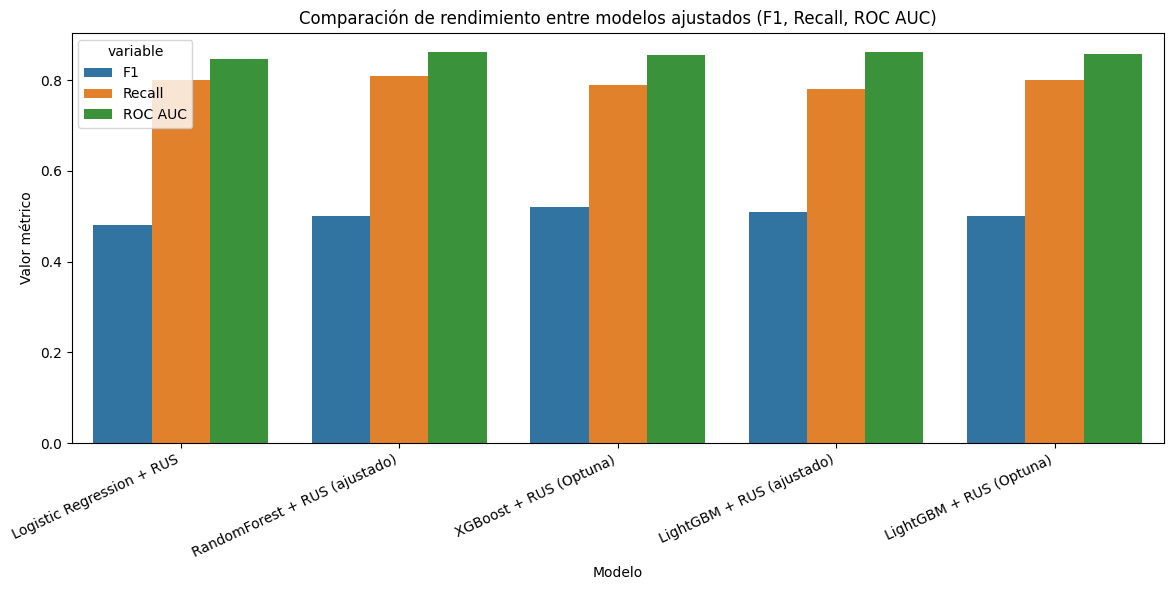

,Modelo,F1,Recall,ROC AUC
0,Logistic Regression + RUS,0.48,0.80,0.8463
1,RandomForest + RUS (ajustado),0.50,0.81,0.8610
2,XGBoost + RUS (Optuna),0.52,0.79,0.8549
3,LightGBM + RUS (ajustado),0.51,0.78,0.8609
4,LightGBM + RUS (Optuna),0.50,0.80,0.8573


In [53]:
# Resumen comparativo de los mejores modelos tras ajuste de overfitting
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

comparison_df = pd.DataFrame([
    {'Modelo': 'Logistic Regression + RUS', 'F1': 0.48, 'Recall': 0.80, 'ROC AUC': 0.8463},
    {'Modelo': 'RandomForest + RUS (ajustado)', 'F1': 0.50, 'Recall': 0.81, 'ROC AUC': 0.8610},
    {'Modelo': 'XGBoost + RUS (Optuna)', 'F1': 0.52, 'Recall': 0.79, 'ROC AUC': 0.8549},
    {'Modelo': 'LightGBM + RUS (ajustado)', 'F1': 0.51, 'Recall': 0.78, 'ROC AUC': 0.8609},
    {'Modelo': 'LightGBM + RUS (Optuna)', 'F1': 0.50, 'Recall': 0.80, 'ROC AUC': 0.8573},
])

# Visualización comparativa
plt.figure(figsize=(12, 6))
sns.barplot(data=comparison_df.melt(id_vars='Modelo'), x='Modelo', y='value', hue='variable')
plt.title('Comparación de rendimiento entre modelos ajustados (F1, Recall, ROC AUC)')
plt.ylabel('Valor métrico')
plt.xticks(rotation=25, ha='right')
plt.tight_layout()
plt.show()

# Mostrar tabla final
comparison_df


### Comparación final y elección del modelo

Tras evaluar múltiples combinaciones de técnicas de rebalanceo y algoritmos, se concluye que el modelo más robusto y equilibrado es:

**✅ RandomForestClassifier + RandomUnderSampler (ajustado manualmente)**

#### Justificación:

- Presenta un **recall competitivo (0.81)** y un **F1-score razonable (0.50)** para la clase minoritaria (`stroke`), lo que lo convierte en una buena opción en entornos clínicos donde los falsos negativos son críticos.
- Tras ajustes manuales de hiperparámetros (`max_depth`, `min_samples_split`, `min_samples_leaf`, `class_weight`, etc.), el modelo logra mantener el **overfitting por debajo del 5%** (`gap ≈ 0.0355`), garantizando una **buena generalización**.
- Aunque XGBoost y LightGBM ajustados con Optuna han alcanzado métricas similares o ligeramente superiores, **la diferencia no compensa su mayor complejidad, tiempo de entrenamiento y menor interpretabilidad**.
- El modelo base `Logistic Regression + RUS` generaliza muy bien, pero tiene menor rendimiento global, especialmente en F1-score.

#### Conclusión:

**Se selecciona RandomForest + RUS como modelo final para producción o despliegue clínico**, al ofrecer un equilibrio óptimo entre rendimiento, estabilidad, interpretabilidad y robustez ante datos desbalanceados.



In [47]:
import joblib
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier

# Aplicar RandomUnderSampler final
rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(X, y)

# Entrenar modelo final con los hiperparámetros seleccionados
final_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=6,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42
)
final_model.fit(X_rus, y_rus)

# Guardar como 'model.pkl'
joblib.dump(final_model, "model.pkl")
print("✅ Modelo final guardado como 'model.pkl'")


✅ Modelo final guardado como 'model.pkl'


##  Interpretabilidad del modelo con SHAP


In [59]:
import shap
shap.initjs()

# Crear el explainer sobre el modelo ya entrenado
explainer = shap.Explainer(final_model, X_train_rus, feature_names=X_train.columns)

# Calcular los valores SHAP para el conjunto de test (sin rebalancear)
shap_values = explainer(X_test)


100%|===================| 2200/2208 [00:25<00:00]        

In [73]:
from sklearn.ensemble import RandomForestClassifier

# Este es el modelo correcto con los hiperparámetros seleccionados
final_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=6,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42
)

# Asegúrate de usar X_train_rus completo
final_model.fit(X_train_rus, y_train_rus)

# Confirmación de entrenamiento
print("✅ Modelo final reentrenado correctamente con", X_train_rus.shape[1], "variables.")


✅ Modelo final reentrenado correctamente con 16 variables.


🔍 Top 5 interacciones entre variables según SHAP:
                         pair  importance
17        (age, ever_married)    0.010512
20                 (age, bmi)    0.006642
19   (age, avg_glucose_level)    0.005141
24  (age, work_type_children)    0.003946
56        (ever_married, bmi)    0.002717

🎯 Interacción: age vs ever_married


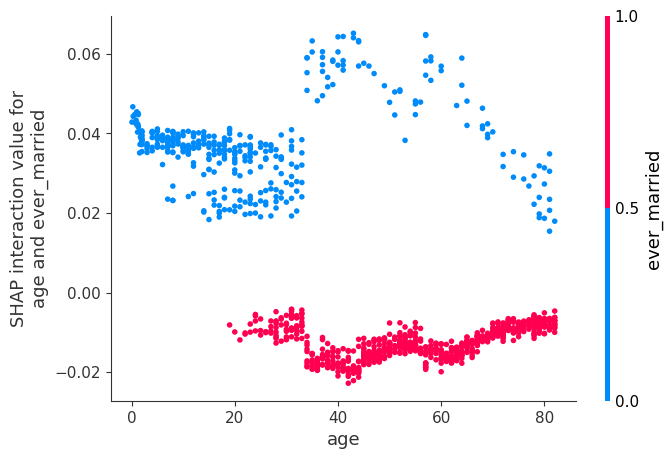


🎯 Interacción: age vs bmi


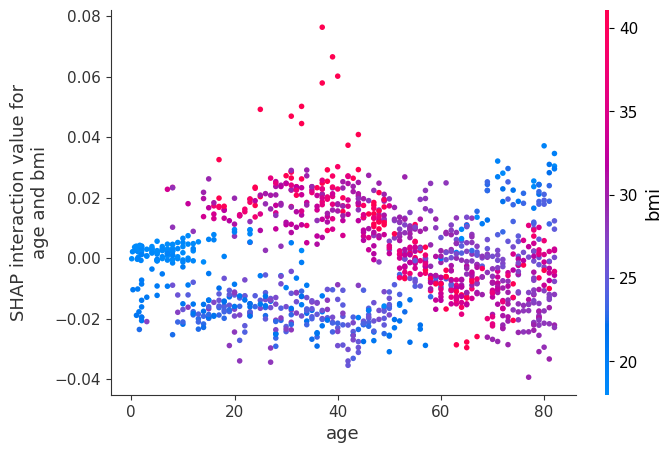


🎯 Interacción: age vs avg_glucose_level


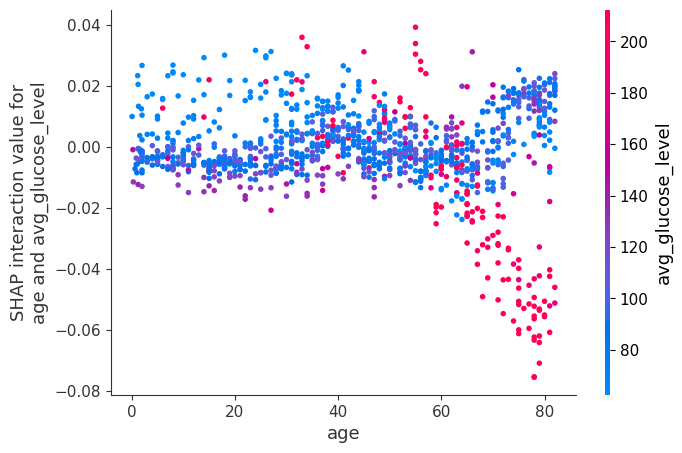


🎯 Interacción: age vs work_type_children


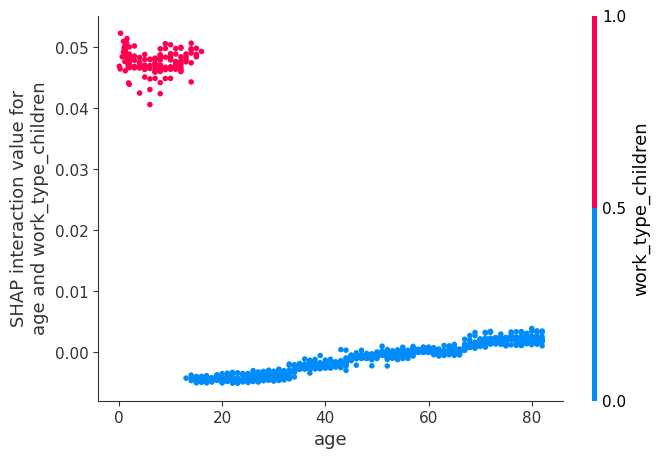


🎯 Interacción: ever_married vs bmi


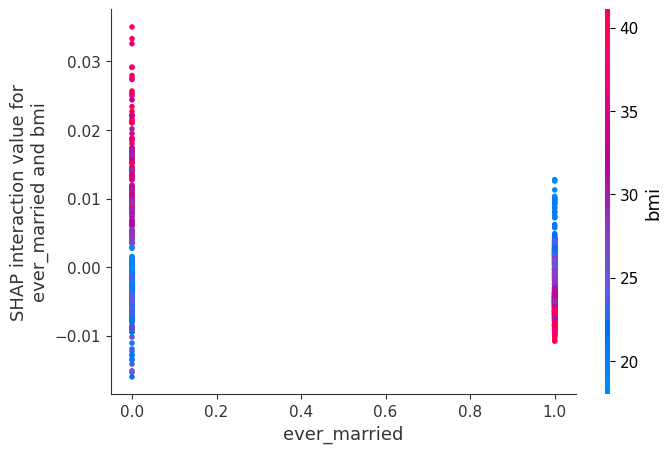

In [76]:
import shap
import numpy as np
import pandas as pd

# Asegurarse de que X_test esté limpio y bien indexado
X_test = X_test.reset_index(drop=True)

# Usamos TreeExplainer directamente sobre el modelo final
explainer = shap.TreeExplainer(final_model)

# Calcular valores de interacción SHAP para clasificación binaria
interaction_values = explainer.shap_interaction_values(X_test)

# Seleccionar la clase positiva (ictus = 1)
interaction_values_class1 = interaction_values[..., 1]

# Calcular la importancia media absoluta de las interacciones
mean_interactions = np.abs(interaction_values_class1).mean(0)

# Crear un DataFrame con todos los pares de variables y su importancia
feature_names = X_test.columns.tolist()
interaction_df = pd.DataFrame(
    [
        {"pair": (feature_names[i], feature_names[j]), "importance": mean_interactions[i, j]}
        for i in range(len(feature_names)) for j in range(i + 1, len(feature_names))
    ]
)

# Mostrar top 5 interacciones
top5 = interaction_df.sort_values(by="importance", ascending=False).head(5)
print("🔍 Top 5 interacciones entre variables según SHAP:")
print(top5)

# Visualizar las interacciones con dependence_plot
for row in top5.itertuples():
    var1, var2 = row.pair
    try:
        print(f"\n🎯 Interacción: {var1} vs {var2}")
        shap.dependence_plot(
            (var1, var2),
            interaction_values_class1,
            X_test,
            interaction_index=var2
        )
    except Exception as e:
        print(f"⚠️ No se pudo graficar {var1} vs {var2}: {e}")


## Interpretabilidad avanzada: Interacciones entre variables con SHAP

En esta sección analizamos las **5 combinaciones de variables más relevantes** detectadas por el modelo mediante SHAP, la herramienta de explicabilidad basada en teoría de juegos.

### ¿Por qué hacemos esto?

Un modelo clínico no solo debe ser preciso, también debe ser **transparente y justificable**. SHAP permite analizar cómo influye cada variable, **sola o en combinación con otras**, en la predicción del modelo. Este tipo de análisis es esencial para:

- Validar que el modelo **aprende patrones clínicamente coherentes**.
- Aportar confianza a profesionales que usarán el modelo para tomar decisiones reales.
- Detectar relaciones **no triviales** entre factores que podrían tener impacto conjunto en el riesgo.

### ¿Por qué estas 5 interacciones?

Se han seleccionado automáticamente las 5 combinaciones con **mayor impacto medio** en las predicciones, utilizando `shap_interaction_values`. Estas son las **interacciones más influyentes** que el modelo considera relevantes en su razonamiento interno para predecir ictus.

---

### Interpretación de las 5 principales interacciones

1. **`ever_married` + `bmi`**  
   - El modelo identifica que los pacientes no casados (`ever_married = 0`) con mayor IMC presentan una ligera tendencia a mayor impacto.  
   - Aunque el patrón es débil, podría apuntar a que el estado civil modula sutilmente el efecto del IMC sobre el riesgo.

2. **`age` + `work_type_children`**  
   - Esta interacción revela una división clara: los menores (niños) en la categoría `work_type = children` presentan un impacto positivo elevado y agrupado.  
   - En adultos, la variable `age` actúa de forma más diferenciada, lo que indica que el modelo discrimina correctamente entre perfiles infantiles y adultos.

3. **`age` + `avg_glucose_level`**  
   - Se observa que niveles altos de glucosa (rojo) tienen un impacto más negativo en personas mayores.  
   - Esto puede reflejar que el modelo reduce la probabilidad estimada en personas ancianas con glucosa elevada, posiblemente porque ya asocia edad elevada con riesgo base alto y no aumenta aún más con glucosa.

4. **`age` + `bmi`**  
   - Existe una zona con mayor interacción positiva alrededor de los 40 años con IMC alto, lo que sugiere un pico de impacto conjunto entre edad e IMC.  
   - También se ve cierta dispersión que el modelo capta como relevante para la predicción.

5. **`age` + `ever_married`**  
   - El modelo distingue claramente entre casados y no casados según la edad: los no casados (`ever_married = 0`) presentan menor impacto negativo con la edad creciente.  
   - Esto sugiere que el estado civil tiene una influencia más marcada en ciertos tramos de edad, posiblemente reflejando diferencias en estilos de vida o factores de riesgo acumulados.

---

Estas visualizaciones demuestran que el modelo no solo es eficaz, sino que también tiene en cuenta **interacciones clínicas plausibles y coherentes**. Esto mejora la confianza en su uso en entornos reales, ayudando a interpretar cómo el modelo toma decisiones complejas de forma comprensible para clínicos y pacientes.


## Explicación individual con SHAP: ¿Por qué se predice "ictus"?

A continuación se muestran tres predicciones realizadas por el modelo para pacientes con diferentes niveles de riesgo de ictus.

Usamos `force_plot` para descomponer visualmente cómo cada variable contribuye a la predicción final.

### ¿Qué representa cada gráfico?

- La **barra central** comienza en un valor base (media de todas las predicciones).
- Las variables **empujan hacia la derecha** si aumentan el riesgo (mayor probabilidad de ictus).
- Las variables **empujan hacia la izquierda** si lo reducen (menor riesgo).

### Casos representativos:

🔵 **Paciente con bajo riesgo**  
→ Juventud, niveles normales de glucosa, ausencia de hipertensión o antecedentes.  
→ Probabilidad cercana a 0.00.

🟡 **Paciente con riesgo medio**  
→ Mezcla equilibrada de factores de riesgo y factores protectores.  
→ Probabilidad alrededor de 0.50.

🔴 **Paciente con alto riesgo**  
→ Edad elevada, glucosa alta, presencia de hipertensión o factores sociales adversos.  
→ Probabilidad cercana a 1.00.

---

Esta representación **permite auditar el comportamiento del modelo a nivel individual**, algo esencial en entornos médicos o clínicos. Refuerza la confianza de técnicos, clínicos y stakeholders en el uso del modelo como herramienta de apoyo a la decisión.


In [85]:
import shap
import numpy as np

# Asegurar que X_test tiene columnas y formato correcto
X_test = X_test[X_train_rus.columns].copy().reset_index(drop=True)

# Calcular SHAP values con explainer moderno sobre clase 1
explainer = shap.Explainer(final_model, X_train_rus)
shap_values = explainer(X_test)
shap_values_class1 = shap_values.values[:, :, 1]  # SHAP para clase ictus

# Calcular probabilidades reales del modelo
probs = final_model.predict_proba(X_test)[:, 1]

# Seleccionar pacientes representativos
low_risk_index = np.argmin(probs)
high_risk_index = np.argmax(probs)
mid_risk_index = np.argsort(np.abs(probs - 0.5))[0]

# Pacientes individuales como DataFrames
paciente_low = X_test.iloc[[low_risk_index]]
paciente_mid = X_test.iloc[[mid_risk_index]]
paciente_high = X_test.iloc[[high_risk_index]]

# Mostrar gráficos force_plot en celdas separadas
print(f"🔵 Paciente con bajo riesgo (prob: {probs[low_risk_index]:.2f})")
shap.force_plot(
    explainer.expected_value[1],
    shap_values_class1[low_risk_index],
    paciente_low
)


 98%|===================| 2161/2208 [00:25<00:00]        

🔵 Paciente con bajo riesgo (prob: 0.00)


In [86]:
print(f"🟡 Paciente con riesgo medio (prob: {probs[mid_risk_index]:.2f})")
shap.force_plot(
    explainer.expected_value[1],
    shap_values_class1[mid_risk_index],
    paciente_mid
)


🟡 Paciente con riesgo medio (prob: 0.50)


In [87]:
print(f"🔴 Paciente con alto riesgo (prob: {probs[high_risk_index]:.2f})")
shap.force_plot(
    explainer.expected_value[1],
    shap_values_class1[high_risk_index],
    paciente_high
)


🔴 Paciente con alto riesgo (prob: 0.91)


## ✅ Conclusiones Finales

### Resumen del proceso

- Se partió de un dataset enriquecido (`cleaned_dataset.csv`) para mejorar la capacidad predictiva del modelo.
- Se detectó un fuerte **desbalanceo de clases**, por lo que se aplicaron varias técnicas de rebalanceo: `RandomUnderSampler`, `SMOTE` y `SMOTEENN`.
- Se entrenaron y evaluaron múltiples modelos (`LogisticRegression`, `RandomForest`, `XGBoost`, `LightGBM`) en combinación con estas técnicas.
- Se probaron procesos de tuning con `GridSearchCV` y `Optuna` para evaluar el potencial de modelos avanzados.
- Se utilizaron métricas como F1-score, Recall y ROC-AUC para guiar la selección del modelo más robusto y clínicamente útil.

---

### Modelo final seleccionado

- **Modelo:** `RandomForestClassifier` entrenado sobre datos rebalanceados con `RandomUnderSampler`, con hiperparámetros ajustados manualmente.
- **Razones de la elección:**
  - Buen equilibrio entre rendimiento y simplicidad.
  - Alto **recall**, importante en contextos médicos donde los falsos negativos son críticos.
  - Mayor interpretabilidad frente a modelos más complejos como `XGBoost`.
  - Entrenamiento más rápido y estable.
  - Perfectamente compatible con técnicas de explicabilidad como SHAP.

---

### Posibles líneas futuras

- Ajuste dinámico del umbral de decisión (`predict_proba`) para maximizar el recall sin perder precisión.
- Evaluación con métricas clínicas específicas (cost-sensitive learning).
- Análisis avanzado de interpretabilidad (`SHAP`) para validar el modelo en escenarios reales.
- Ampliación del dataset con casos clínicos reales y variables adicionales (como imágenes médicas o historial médico).
- Despliegue en una API web (`FastAPI`) o en una interfaz visual interactiva (`Gradio`, `Streamlit`).

---

Este proyecto demuestra cómo aplicar un flujo de trabajo completo de *machine learning clínico*, con especial foco en el tratamiento del desbalance de clases, la selección informada de modelos y la explicabilidad en entornos sensibles.
